<a href="https://colab.research.google.com/github/tinahuang222/COVID_diagnostics/blob/master/COVID_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning Objectives
(reference:[helper functions will be included in this environment](https://github.com/tinahuang222/COVID_diagnostics))

The objective of this assignment is to gain experience implementing machine learning approaches to classify medical images. I will implement two machine learning-based approaches to analyze a collection of chest x-rays containing normal, pneumonia, and COVID-19 cases.

There are two approaches in generating radiomics features from lung masks using UNet. First approach is extracting features from 3 randomly selected patches from the lung region highlighted by the mask. Second approach is extracting feature directly from entire lung masks. Comparing the performances of features extracted from approaches, 
I will evaluate the performances of random forest classifier in 2 task predictions using the extracted features from two approaches.


> Input: Given a full chest x-ray of a patient
Output: Generate two predictions

*   A probability between 0 and 1 representing the likelihood that the chest x-ray is Abnormal (Normal versus Pneumonia & COVID-19) 
*   A probability between 0 and 1 representing the likelihood that the abnormal chest x-ray is COVID-19 (Pneumonia versus COVID-19)

The dataset is a combination of the public IEEE8023 image dataset and the RSNA pneumonia challenge dataset.
Instructions on how the dataset was generated are available here: https://github.com/lindawangg/COVID-Net/

Data Use Agreement
The data comes from both public and semi-private sources. The IEEE8023 dataset is publicly available and freely distributable. The RSNA pneumonia challenge was made available as part of a Kaggle challenge. Given that the provided data are a combination of these datasets, redistribution or usage of the train and test files is not allowed beyond the scope of this course. Please see the Challenge website for restrictions on the use of the data https://www.kaggle.com/c/rsna-pneumonia-detection-challenge.

**Highlights to this project:**
- These two approaches are not successful. The results for both predictions from both approaches have similar performances AUC-ROC (0.5+-0.01) and low average precision (0.02+-0.1). Class imbalance plays a crucial role in lowering the precision. Future experiment should address this issue by data augmentation using linear transformation on original images or generative adversarial network. 


In [0]:
import os
import numpy as np
import cv2 as cv 
import pandas as pd

In [0]:
from google.colab import drive 

# Preparation

In [5]:
drive.mount('/mntDrive') 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /mntDrive


In [6]:
cd '/mntDrive/My Drive/Colab Notebooks/COVID19_project'

/mntDrive/My Drive/Colab Notebooks/COVID19_project


In [4]:
import helper_functions as hf

ModuleNotFoundError: ignored


**Look at the metadata file**

In [0]:
data_folder = "train"
label_file = "train_split_v2.txt"

In [6]:
_datalabel= pd.read_csv("train_split_v2.txt", sep= ' ', header = None, names = ['unimp', 'file_name', 'label'], dtype = object)
_datalabel.drop(["unimp"], axis = 1, inplace = True)
_datalabel.head()

,file_name,label
0,SARS-10.1148rg.242035193-g04mr34g0-Fig8a-day0....,pneumonia
1,SARS-10.1148rg.242035193-g04mr34g0-Fig8b-day5....,pneumonia
2,SARS-10.1148rg.242035193-g04mr34g0-Fig8c-day10...,pneumonia
3,SARS-10.1148rg.242035193-g04mr34g04a-Fig4a-day...,pneumonia
4,SARS-10.1148rg.242035193-g04mr34g04b-Fig4b-day...,pneumonia


In [7]:
_datalabel['label'].value_counts()

pneumonia    8521
normal       7966
COVID-19       89
Name: label, dtype: int64

In [0]:
dict_label = dict(zip(_datalabel['file_name'], _datalabel['label']))

# Configure keras and tensorflow setting

In order to use the [UNet in lung segmentation](https://github.com/imlab-uiip/lung-segmentation-2d.git), the local environment must configure to tensorflow_version 1.1.0, keras == 2.0.4, and run in python2.7(This is critical). 

In [0]:
%tensorflow_version 1.1.0

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.1.0`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


In [0]:
!pip install q keras==2.0.4

     |████████████████████████████████| 204kB 3.7MB/s 
  Created wheel for keras: filename=Keras-2.0.4-cp36-none-any.whl size=235518 sha256=568428da834fe0483ad4903929796c09f930785c3717010d363256f89c5cd532
  Stored in directory: /root/.cache/pip/wheels/92/11/19/2b4dda9f2301c140d1ac59460321c5be612c7cde4f26a8b8be
Successfully built keras
ERROR: textgenrnn 1.4.1 has requirement keras>=2.1.5, but you'll have keras 2.0.4 which is incompatible.
  Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1


In [1]:
#check the version
import tensorflow as tf 
import keras
print(tf.__version__)
print(keras.__version__)

2.2.0-rc3
2.3.1


Using TensorFlow backend.


# Lung Region Segmentation using U-Net based Method

In [0]:
# this will pull the lung
#! git clone https://github.com/imlab-uiip/lung-segmentation-2d.git

Cloning into 'lung-segmentation-2d'...
remote: Enumerating objects: 51, done.
remote: Total 51 (delta 0), reused 0 (delta 0), pack-reused 51
Unpacking objects: 100% (51/51), done.


In [0]:
#create csv file to write down img and mask
img_name = list(_datalabel['file_name'])
img_ext = set(map(lambda x: os.path.splitext(x)[1], img_name))
print("set of ext used in img: ", img_ext)

#mask will have the same name as img_name except all file should be in '.png' 
mask_name = list(map(lambda x: os.path.splitext(x)[0] + '.png', img_name))

_maskfile_lookup = pd.DataFrame({'img': img_name,'mask': mask_name})
_maskfile_lookup.head()
_maskfile_lookup_path = '_maskfile_lookup.csv'
_maskfile_lookup.to_csv(_maskfile_lookup_path, index = None)
print("maskfile name is now ready under : ", _maskfile_lookup_path)

('set of ext used in img: ', set(['.jpg', '.jpeg', '.png']))
('maskfile name is now ready under : ', '_maskfile_lookup.csv')


Create the mask by invoking lung-segmentation-2d


In [0]:
from lungseg import load_data 
from lungseg import inference 
from keras.models import load_model 
from keras.preprocessing.image import ImageDataGenerator
from skimage import morphology, io, color, exposure, img_as_float, transform
from skimage import transform
import helper_functions as hf

Load training data 

In [0]:
# load filenames under train path  
_rootdir = '/mntDrive/My Drive/Colab Notebooks/COVID19_project'
_datapath = os.path.join(_rootdir, "train")
_filenames = os.listdir(os.path.join(_rootdir, _datapath)) 

#only include filenames with '.jpeg' and '.jpg' '.png' extensions
_filenames= hf.get_filenames_at(_datapath,{'.jpeg', '.jpg','.png'})

#check if all filenames only include permited_ext
print("only included _filenames with extensions: \n", hf.get_fileext(_filenames))

In [0]:
_topath = "mask"
_already_saved_masks = os.listdir("/mntDrive/My Drive/Colab Notebooks/COVID19_project/mask")

In [0]:
print "already saved" , len(_already_saved_masks)
print "needed more :",  len(_filenames) - len(_already_saved_masks)


In [0]:
#only run on files did not finish running or did not save properly
_errorfiles = ['afbe84b7-428f-45d7-8d51-8b54a7547c98.npy']
               
#get all the finished task's names 
_already_saved_mask_names = set(_already_saved_masks) - set(_errorfiles)
_already_saved_mask_names = set(map(lambda x: os.path.splitext(x)[0], _already_saved_masks))

_unfinished_filenames = _errorfiles
for x in _filenames:
  if os.path.splitext(x)[0] not in _already_saved_mask_names:
    _unfinished_filenames.append(x)

print "# of _unfinished_filenames: ", len(_unfinished_filenames)
_unfinished_filenames[:5]

# of _unfinished_filenames:  1


['afbe84b7-428f-45d7-8d51-8b54a7547c98.npy']

In [0]:
# Load model
model_name = 'lungseg/trained_model.hdf5'
UNet = load_model(model_name)  
test_gen = ImageDataGenerator(rescale=1.)

In [0]:
UNet

In [0]:
_topath = "mask"

#catch any error files in creating this
error_files = []
dim = []
im_shape = (256,256)

leftover = len(_file_nomasks)
print "# of remaining", leftover

for filename in _file_nomasks: 
  try:
    #mask is a dummy variable 
    pd_filename = pd.DataFrame({'name': [filename], 'mask': [filename]})
    _maskpath = os.path.join(_topath, os.path.splitext(filename)[0]+'.npy')

    #prepare X
    X, y = load_data.loadDataGeneral(pd_filename,_datapath,im_shape)
    inp_shape = X.shape
    img = exposure.rescale_intensity(np.squeeze(X), out_range=(0,1))
    
    # from (1,256,256,1) to (256,256) 
    pred = UNet.predict(X)[..., 0].reshape((256,256))

    #produce a binary mask from pred with a threshold of 0.5
    pr = pred > 0.5
    pr = inference.remove_small_regions(pr, 0.02 * np.prod(im_shape))

    #pr_resized = transform.resize(pr, (1024, 1024))
    np.save(_maskpath, pr)
    leftover = leftover - 1
    print("# of remaining: ", leftover)
    print("Successfully saved mask to: ", _maskpath)
    
  except:
    error_files.append(filename)
print("Successfully saved mask to all, except for ", len(error_files), " files")


# of remaining 0
('Successfully saved mask to all, except for ', 0, ' files')


# Randomly sample an area on images

After we obtained the masks for each images, let's visualized what's happening in there 



In [0]:
import helper_functions as hf
from google.colab.patches import cv2_imshow
import ROI_helper as rh 

**Preparation in loading images and masks** 

In [0]:
# get all errorfiles, recall we have _filenames,  
_masknames = hf.get_filenames_at("mask", {'.npy'})
_filenames = hf.get_filenames_at("train", {'.jpeg', '.jpg', '.png'})
errorfiles, m_len = hf.missingfiles(_filenames, _masknames)

#error filenames
_file_nomasks= hf.get_files_withnames(_filenames, set(errorfiles))

#_filenames
_filenames_masks = list(set(_filenames) - set(_file_nomasks))

print("# of error_files: ", len(_file_nomasks))

## check whether # of train data have same number of mask
# expect true
# Now, it should have matching _filenames -> _masksnames
print("Do all filenames have matching masks?", len(_filenames_masks) == len(_masknames))

('# of error_files: ', 0)
('Do all filenames have matching masks?', True)


In [0]:
reload(rh)
tmp = (0, 0)
# check whether patchInBound function works
print(rh.patchInBound(tmp, (2,2),(2,2)) == True)
print(rh.patchInBound(tmp, (1,1),(2,2)) == True)
print(rh.patchInBound(tmp, (2,2),(1,2)) == False)
print(rh.patchInBound(tmp, (3,3),(2,2)) == False)

True
True
True
True


## **Visualize Images**

In [0]:
from matplotlib import pyplot as plt
import matplotlib.patches as patches


**Visualize the masks overlaying on img**

/usr/local/lib/python2.7/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python2.7/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Successful resizing (img, mask)


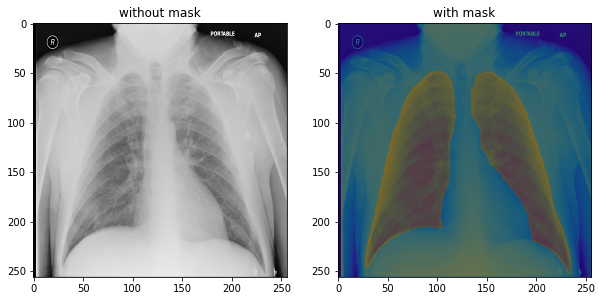

In [0]:
# try visualizing an instance of images + mask
i = _filenames_masks[2]
m_i = os.path.splitext(i)[0] + '.npy'

try:
  img = cv.imread(os.path.join("train", i), 0)
  mask = np.load(os.path.join("mask", m_i), allow_pickle = True)

  #turn probability into a boolean 0,1 if nonzero
  r_img, r_mask = rh.resize_both(img, mask, (256,256))
  r_mask[r_mask > 0] = 1
 
  # axes are in a two-dimensional array, indexed by [row, col]
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
  axes[0].imshow(r_img, cmap= 'gray', origin = 'upper')
  axes[0].set_title('without mask')

  axes[1].imshow(r_img,origin = 'upper')  
  axes[1].imshow(r_mask, cmap ='jet', alpha = 0.5, origin = 'upper')
  axes[1].set_title('with mask') 

  fig
except:
  print("Can't even read img, mask")

**Visualize a patch selection instances**

False


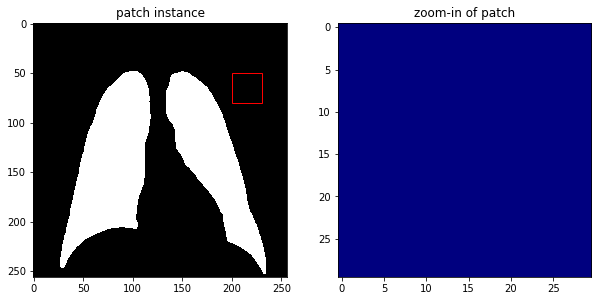

In [0]:
reload(rh)
#test whether I could arbitrarily choose a patch and draw 
ht,width = (30,30)
x, y= (200,50)
patch = r_mask[y:y+ht, x:x+width]

#test drawRect and see does isGoodPatch evaluator works.
print(rh.isGoodPatch(patch, .70))
rh.drawRect(r_mask, (x,y), (ht,width), patch)

**Randomly select ROI with overlay masks+image to extract texture info**

**Select random patches from specific mask **

Below is a demonstration of how to use this

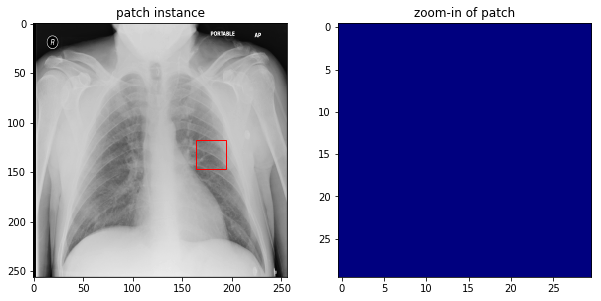

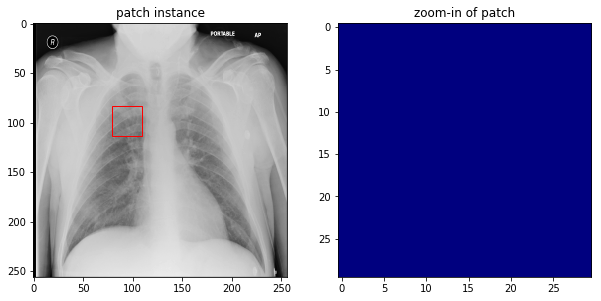

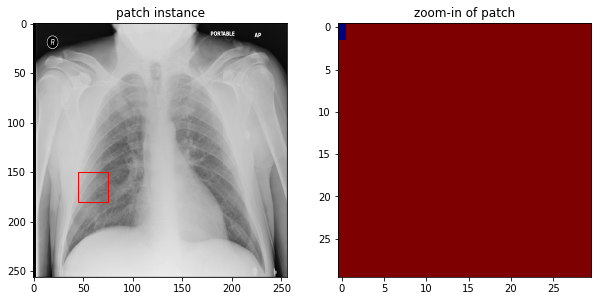

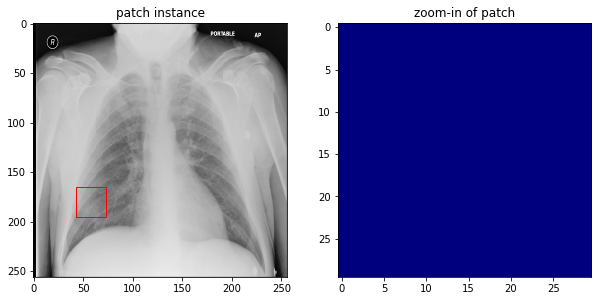

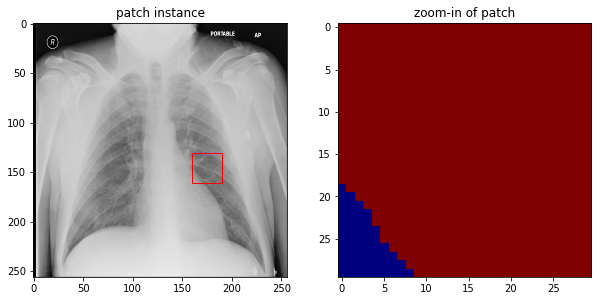

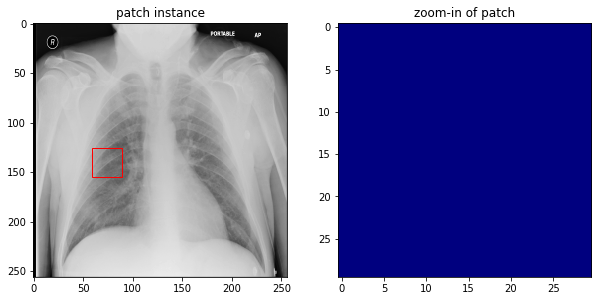

In [0]:
reload(rh)
rand_patches_masks = rh.gen_patches_helper(r_img, r_mask, patch_size=(30,30),
                     num_patch=5, t_mask = .1, t_patch = .9,
                     on_visual = True) 

In [0]:
leftover = len(_filenames_masks) - 6478
print(leftover)

3022


**Generate patches for all train_data**

In [0]:
reload(rh)
genpatchERROR = []
leftover = len(_filenames_masks)
for filename in _filenames_masks:
  try:
    rh.gen_patches(filename, _datapath = "train", _maskpath = "mask", _topath ="patch")
  except:
    genpatchERROR.append(filename)
  leftover -= 1
  print("Remaining: ", leftover)
np.save("error.npy", np.array(genpatchERROR))

In [0]:
error_file = np.load("error.npy")
len(error_file)
error_file

array(['afbe84b7-428f-45d7-8d51-8b54a7547c98.png'], dtype='|S40')

In [0]:
error = 'afbe84b7-428f-45d7-8d51-8b54a7547c98.png'

In [0]:
reload(rh)
reload(hf)
_patchfiles = hf.get_filenames_at("patch", {'.npy'})
_genpatchERROR = hf.missingfiles(_filenames_masks, _patchfiles)
print("# of patch generation error", _genpatchERROR) 

('# of patch generation error', (['afbe84b7-428f-45d7-8d51-8b54a7547c98'], 1))


# Extract Texture Information

From the training data + mask, extract texture information using PyRadiomics 

**Install PyRadiomics**

In [0]:
!pip install pyradiomics

##**Extract radiomics features from masks + patches**

In [0]:
from radiomics import glcm, imageoperations, shape, glrlm, glszm, getTestCase
from radiomics import featureextractor
import feature_extraction as fe
import SimpleITK as sitk

In [0]:
reload(fe)
reload(rh)
reload(hf)

<module 'helper_functions' from 'helper_functions.pyc'>

***recall _filenames_masks***

In [0]:
# get all errorfiles, recall we have _filenames,  
_masknames = hf.get_filenames_at("mask", {'.npy'})
_filenames = hf.get_filenames_at("train", {'.jpeg', '.jpg', '.png'})
errorfiles, m_len = hf.missingfiles(_filenames, _masknames)

#error filenames
_file_nomasks= hf.get_files_withnames(_filenames, set(errorfiles))

#_filenames
_filenames_masks = list(set(_filenames) - set(_file_nomasks))

print("# of error_files: ", len(_file_nomasks))

## check whether # of train data have same number of mask
# expect true
# Now, it should have matching _filenames -> _masksnames
print("Do all filenames have matching masks?", len(_filenames_masks) == len(_masknames))

('# of error_files: ', 0)
('Do all filenames have matching masks?', True)


In [0]:
_traindir = "train"
_maskdir = "mask"
_patch_texturedir = "patch_features"
_mask_texturedir = "mask_features"
_ERRORdir = "ERROR_LOG"
#check to see if directories existed
hf.checkDir(_patch_texturedir)
hf.checkDir(_mask_texturedir)
hf.checkDir(_ERRORdir)

_PATCHERROR = []

#if True:
for _datapath in _filenames_masks:
  # edit this out... when scaled up
  _maskpath = os.path.splitext(_datapath)[0] + '.npy'

  # save name 
  _mask_fpath = os.path.splitext(_datapath)[0] + '_fmask.csv'
  _patch_fpath = os.path.splitext(_datapath)[0] + '_fpatch.csv'
  
  #if True:
  try:
      #read imgs and masks
    img = cv.imread(os.path.join(_traindir, _datapath), 0)
    mask = np.load(os.path.join(_maskdir, _maskpath), allow_pickle= True)

    #scale the img and masks
    r_img,r_mask = rh.resize_both(img, mask, (256,256))
    r_mask[r_mask > 0]= 1

    #generate features for patches
    patches = rh.gen_patches_helper(r_img, r_mask, patch_size=(30,30), num_patch=3,t_mask=0.5, t_patch=.70, on_visual = False)
    pd_features = pd.DataFrame()
    for i in patches:
      #patch= rh.gen_patches(filename, _datapath = "train", _maskpath = "mask",_topath ="patch", num_patch = 1)
      features =  fe.extract_features_from_mask_helper(r_img, i)
      tmp = pd.DataFrame.from_dict(features, orient='index').transpose()
      pd_features = pd.concat([pd_features, tmp], axis = 0)

    pd_features.to_csv(os.path.join(_patch_texturedir, _patch_fpath), index = False)  
    print("sucessfully generated patches' texture features: ", _datapath)

    #generate features for entire mask area
    mask_features = fe.extract_features_from_mask_helper(r_img, r_mask)
    pd_maskfeatures = pd.DataFrame.from_dict(mask_features, orient='index').transpose()
    pd_maskfeatures.to_csv(os.path.join(_mask_texturedir, _mask_fpath), index = False)  
    print("sucessfully generated masks' texture features:",  _datapath)
  
  except:
    _PATCHERROR.append(_datapath)
    print("Some error in", _datapath, "\n\n")
np.save(os.path.join(_ERRORdir, "FEATURE_ERRORLOG2.npy"), _PATCHERROR)

Streaming output truncated to the last 5000 lines.
("sucessfully generated masks' texture features:", '943b27f1-ba1c-415b-b738-7b52aefa445b.png')
Successful resizing (img, mask)
("sucessfully generated patches' texture features: ", '391a0d8a-9d87-4420-9e76-2bd87dbce5a3.png')
("sucessfully generated masks' texture features:", '391a0d8a-9d87-4420-9e76-2bd87dbce5a3.png')
Successful resizing (img, mask)
("sucessfully generated patches' texture features: ", '61d1d633-b916-4c45-bdd4-cbd800153f00.png')
("sucessfully generated masks' texture features:", '61d1d633-b916-4c45-bdd4-cbd800153f00.png')
Successful resizing (img, mask)
("sucessfully generated patches' texture features: ", '46a684b6-d62e-4d60-a053-af6a53578f07.png')
("sucessfully generated masks' texture features:", '46a684b6-d62e-4d60-a053-af6a53578f07.png')
Successful resizing (img, mask)
("sucessfully generated patches' texture features: ", '41247428-2833-40c1-9fb2-4e1c59d165af.png')
("sucessfully generated masks' texture features:"

These are error files from feature generation

In [0]:
_PATCHERROR

['afbe84b7-428f-45d7-8d51-8b54a7547c98.png',
 '584f7e37-6bbf-4194-b671-61bcf49c56e5.png',
 '8a6eb7c9-81ff-43c3-81d8-85922e96507e.png',
 '7f86ef64-225c-44ba-a1ab-e4ec82945ff0.png',
 '73286fe9-2e42-4a75-b071-a4c2173672a4.png',
 '8b60f253-6ae0-4b16-89bc-f3e3163dbbae.png',
 '308cf5b6-fcaf-4673-bc75-737b8d67b889.png']

Double check to see whether errors come from COVID-19 group.

In [0]:
import feature_extraction as fe

In [0]:
# get all errorfiles, recall we have _filenames,  
_maskfeatures = hf.get_filenames_at("mask_features", {'.csv'})
_patchfeatures = hf.get_filenames_at("patch_features", {'.csv'})
_filenames = hf.get_filenames_at("train", {'.jpeg', '.jpg', '.png'})
error_maskf, m_len = hf.missingfiles(_filenames,_maskfeatures, suffix = '_fmask')
error_patchf, m_len = hf.missingfiles(_filenames, _patchfeatures, suffix = '_fpatch' )
print("# of mask feature errors: ", len(error_maskf))
print("# of patch feature errors: ", len(error_patchf))

#filenames with error files
_file_nomaskf= hf.get_files_withnames(_filenames, set(error_maskf))
_file_nopatchf= hf.get_files_withnames(_filenames, set(error_patchf))

#_filenames
_filenames_maskf = list(set(_filenames) - set(_file_nomaskf))
_filenames_patchf = list(set(_filenames) - set(_file_nopatchf))

## check whether # of train data have same number of mask (sanity check)
print("Do all filenames have matching masks?", len(_filenames_maskf) == len(error_maskf))
print("Do all filenames have matching masks?", len(_filenames_patchf) == len(error_patchf))

('# of mask feature errors: ', 15)
('# of patch feature errors: ', 1)
('Do all filenames have matching masks?', False)
('Do all filenames have matching masks?', False)


In [0]:
reload(hf)
Y, workingfilenames= hf.getYfrom(dict_label, _filenames)
Y_mask, _filenames_maskf= hf.getYfrom(dict_label, _filenames_maskf)
Y_patch, _filenames_patchf= hf.getYfrom(dict_label, _filenames_patchf)

print("Y \n", hf.class_counts(Y))
print("Y_mask \n" , hf.class_counts(Y_mask))
print("Y_patch \n" , hf.class_counts(Y_patch))

('Y \n', {'pneumonia': 3926, 'COVID-19': 46, 'normal': 5500})
('Y_mask \n', {'pneumonia': 3916, 'COVID-19': 45, 'normal': 5496})
('Y_patch \n', {'pneumonia': 3925, 'COVID-19': 46, 'normal': 5500})


Noted that label metafiles included more labels than training data is provided to us. We also see that most of the missing files are pneumonia and normal, and only 1 is missing for COVID19, so we will throw away the non-working one since they have a relatively large sample size. 

##**Aggregate features for masks + patches**

Using the features generated from masks + patches, we should aggregate the files into training set. 
-------------------------

---



First, aggregate texture features for the masks only into mask_aggregator.csv

In [0]:
X= list(hf.get_names(_filenames_maskf))
aggr = pd.DataFrame()
Y_mask
for x,y in list(zip(X, Y_mask)):
  x = x + '_fmask'
  try:
    tmp = pd.read_csv(os.path.join("mask_features", x+'.csv'), index_col = None)
    tmp['y'] = y
    aggr = pd.concat([aggr,tmp], axis = 0)
  except:
    continue 
aggr.to_csv("mask_aggregator.csv", index = None)
aggr.head()

,original_gldm_GrayLevelVariance,original_gldm_HighGrayLevelEmphasis,original_gldm_DependenceEntropy,original_gldm_DependenceNonUniformity,original_gldm_GrayLevelNonUniformity,original_gldm_SmallDependenceEmphasis,original_gldm_SmallDependenceHighGrayLevelEmphasis,original_gldm_DependenceNonUniformityNormalized,original_gldm_LargeDependenceEmphasis,original_gldm_LargeDependenceLowGrayLevelEmphasis,original_gldm_DependenceVariance,original_gldm_LargeDependenceHighGrayLevelEmphasis,original_gldm_SmallDependenceLowGrayLevelEmphasis,original_gldm_LowGrayLevelEmphasis,original_glcm_JointAverage,original_glcm_SumAverage,original_glcm_JointEntropy,original_glcm_ClusterShade,original_glcm_MaximumProbability,original_glcm_Idmn,original_glcm_JointEnergy,original_glcm_Contrast,original_glcm_DifferenceEntropy,original_glcm_InverseVariance,original_glcm_DifferenceVariance,original_glcm_Idn,original_glcm_Idm,original_glcm_Correlation,original_glcm_Autocorrelation,original_glcm_SumEntropy,original_glcm_MCC,original_glcm_SumSquares,original_glcm_ClusterProminence,original_glcm_Imc2,original_glcm_Imc1,original_glcm_DifferenceAverage,original_glcm_Id,original_glcm_ClusterTendency,original_firstorder_InterquartileRange,original_firstorder_Skewness,...,original_firstorder_Kurtosis,original_firstorder_Mean,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glrlm_GrayLevelVariance,original_glrlm_LowGrayLevelRunEmphasis,original_glrlm_GrayLevelNonUniformityNormalized,original_glrlm_RunVariance,original_glrlm_GrayLevelNonUniformity,original_glrlm_LongRunEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_RunLengthNonUniformity,original_glrlm_ShortRunEmphasis,original_glrlm_LongRunHighGrayLevelEmphasis,original_glrlm_RunPercentage,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_RunEntropy,original_glrlm_HighGrayLevelRunEmphasis,original_glrlm_RunLengthNonUniformityNormalized,original_glszm_GrayLevelVariance,original_glszm_ZoneVariance,original_glszm_GrayLevelNonUniformityNormalized,original_glszm_SizeZoneNonUniformityNormalized,original_glszm_SizeZoneNonUniformity,original_glszm_GrayLevelNonUniformity,original_glszm_LargeAreaEmphasis,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_ZonePercentage,original_glszm_LargeAreaLowGrayLevelEmphasis,original_glszm_LargeAreaHighGrayLevelEmphasis,original_glszm_HighGrayLevelZoneEmphasis,original_glszm_SmallAreaEmphasis,original_glszm_LowGrayLevelZoneEmphasis,original_glszm_ZoneEntropy,original_glszm_SmallAreaLowGrayLevelEmphasis,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Strength,original_ngtdm_Contrast,original_ngtdm_Busyness,y
0,1.540143,16.901914,3.328322,8978.203827,4859.015090,0.213763,4.371891,0.490880,6.931657,0.628943,0.382087,105.681137,0.017352,0.087630,3.873927,7.747854,3.088494,13.020543,0.299465,0.997354,0.192766,0.217590,0.761285,0.202255,0.173766,0.979141,0.896154,0.923567,16.321926,2.849685,0.926620,1.423410,138.200857,0.960853,-0.587153,0.209341,0.896690,5.476050,32.0,1.150559,...,4.911342,84.903390,0.027061,2.457393,0.076799,0.189993,31.005242,765.862317,51.592657,10.232087,675.638055,0.384225,676.412305,0.220394,5.000189,5.736690,22.708509,0.167611,2.457393,31.005242,0.189993,0.167611,675.638055,765.862317,51.592657,10.232087,0.220394,5.000189,676.412305,22.708509,0.384225,0.076799,5.736690,0.027061,0.001277,6.668316,0.048461,0.008145,19.762871,normal
0,2.134038,13.070236,3.756545,7334.747175,3183.373086,0.221849,3.201704,0.460378,6.643359,1.339756,0.385825,81.702172,0.039155,0.192282,3.261106,6.522212,3.482317,13.828037,0.217358,0.996398,0.127728,0.234330,0.789854,0.230231,0.180439,0.974231,0.884147,0.942831,12.567085,3.239793,0.947955,2.049439,193.519651,0.975142,-0.604080,0.232144,0.884292,7.963425,48.0,0.662674,...,3.064420,94.811574,0.053143,2.415242,0.165134,0.185462,15.128033,736.471166,31.224880,5.815210,611.117854,0.350658,330.170486,0.249247,6.802277,5.775507,15.319819,0.153895,2.415242,15.128033,0.185462,0.153895,611.1

Secondly, aggregate features for patches  

In [0]:
import feature_aggregators as fa

In [0]:
X= list(hf.get_names(_filenames_patchf))
aggr = pd.DataFrame()
for x,y in list(zip(X,Y_patch)):
  if True:
    patches = pd.read_csv(os.path.join("patch_features", x +'_fpatch.csv'), index_col=None)
    tmp = fa.extract_histogram_features_helper(patches)
    tmp['y'] = y
    aggr = pd.concat([aggr,tmp], axis = 0)
  else:
    continue 
aggr.to_csv("patch_aggregator.csv", index = None)
aggr.head()

,original_gldm_GrayLevelVariance_mean,original_gldm_GrayLevelVariance_std,original_gldm_HighGrayLevelEmphasis_mean,original_gldm_HighGrayLevelEmphasis_std,original_gldm_DependenceEntropy_mean,original_gldm_DependenceEntropy_std,original_gldm_DependenceNonUniformity_mean,original_gldm_DependenceNonUniformity_std,original_gldm_GrayLevelNonUniformity_mean,original_gldm_GrayLevelNonUniformity_std,original_gldm_SmallDependenceEmphasis_mean,original_gldm_SmallDependenceEmphasis_std,original_gldm_SmallDependenceHighGrayLevelEmphasis_mean,original_gldm_SmallDependenceHighGrayLevelEmphasis_std,original_gldm_DependenceNonUniformityNormalized_mean,original_gldm_DependenceNonUniformityNormalized_std,original_gldm_LargeDependenceEmphasis_mean,original_gldm_LargeDependenceEmphasis_std,original_gldm_LargeDependenceLowGrayLevelEmphasis_mean,original_gldm_LargeDependenceLowGrayLevelEmphasis_std,original_gldm_DependenceVariance_mean,original_gldm_DependenceVariance_std,original_gldm_LargeDependenceHighGrayLevelEmphasis_mean,original_gldm_LargeDependenceHighGrayLevelEmphasis_std,original_gldm_SmallDependenceLowGrayLevelEmphasis_mean,original_gldm_SmallDependenceLowGrayLevelEmphasis_std,original_gldm_LowGrayLevelEmphasis_mean,original_gldm_LowGrayLevelEmphasis_std,original_glcm_JointAverage_mean,original_glcm_JointAverage_std,original_glcm_SumAverage_mean,original_glcm_SumAverage_std,original_glcm_JointEntropy_mean,original_glcm_JointEntropy_std,original_glcm_ClusterShade_mean,original_glcm_ClusterShade_std,original_glcm_MaximumProbability_mean,original_glcm_MaximumProbability_std,original_glcm_Idmn_mean,original_glcm_Idmn_std,...,original_glszm_ZoneVariance_std,original_glszm_GrayLevelNonUniformityNormalized_mean,original_glszm_GrayLevelNonUniformityNormalized_std,original_glszm_SizeZoneNonUniformityNormalized_mean,original_glszm_SizeZoneNonUniformityNormalized_std,original_glszm_SizeZoneNonUniformity_mean,original_glszm_SizeZoneNonUniformity_std,original_glszm_GrayLevelNonUniformity_mean,original_glszm_GrayLevelNonUniformity_std,original_glszm_LargeAreaEmphasis_mean,original_glszm_LargeAreaEmphasis_std,original_glszm_SmallAreaHighGrayLevelEmphasis_mean,original_glszm_SmallAreaHighGrayLevelEmphasis_std,original_glszm_ZonePercentage_mean,original_glszm_ZonePercentage_std,original_glszm_LargeAreaLowGrayLevelEmphasis_mean,original_glszm_LargeAreaLowGrayLevelEmphasis_std,original_glszm_LargeAreaHighGrayLevelEmphasis_mean,original_glszm_LargeAreaHighGrayLevelEmphasis_std,original_glszm_HighGrayLevelZoneEmphasis_mean,original_glszm_HighGrayLevelZoneEmphasis_std,original_glszm_SmallAreaEmphasis_mean,original_glszm_SmallAreaEmphasis_std,original_glszm_LowGrayLevelZoneEmphasis_mean,original_glszm_LowGrayLevelZoneEmphasis_std,original_glszm_ZoneEntropy_mean,original_glszm_ZoneEntropy_std,original_glszm_SmallAreaLowGrayLevelEmphasis_mean,original_glszm_SmallAreaLowGrayLevelEmphasis_std,original_ngtdm_Coarseness_mean,original_ngtdm_Coarseness_std,original_ngtdm_Complexity_mean,original_ngtdm_Complexity_std,original_ngtdm_Strength_mean,original_ngtdm_Strength_std,original_ngtdm_Contrast_mean,original_ngtdm_Contrast_std,original_ngtdm_Busyness_mean,original_ngtdm_Busyness_std,y
0,0.854314,0.687816,14.437407,12.210298,2.252215,0.837975,601.977037,85.916559,413.975556,211.600782,0.155556,0.017764,2.186132,1.635433,0.668863,0.095463,7.888889,0.439596,1.411411,1.330855,0.212495,0.061043,115.198889,102.976846,0.030381,0.026348,0.182425,0.166694,3.436973,1.642228,6.873946,3.284455,1.900739,0.872426,-6.122102,11.577757,0.572797,0.217801,0.994530,0.004937,...,46.174970,0.346302,0.175537,0.099842,0.024416,10.389025,4.781981,33.835357,13.483991,182.813759,98.637953,2.634697,1.771819,0.115185,0.045601,33.128559,41.454508,2788.711785,3325.609596,12.867086,9.393182,0.231862,0.030477,0.242019,0.231774,4.915035,0.646754,0.073352,0.072024,0.055360,0.033489,0.935561,0.934069,0.667806,0.803514,0.007161,0.001090,3.372891,4.241093,normal
0,1.831465,0.604139,13.767778,7.766166,2.

# **Prediction using Random Forest**


At this point, the algorithm extracted features from 3 randomly selected patches from the lung region highlighted by the mask, and features extracted directly from entire lung region. Comparing the performances of features extracted from approaches, 
I will evaluate the performances of random forest classifier in 2 task predictions using the extracted features from two approaches.
1. Using extracted features, random forest classifier perform classification on normal and abnormal patients (0 for normal and 1 for abnormal). Abnormal patients include both pneumonia and COVID-19 induced pneumonia, and the others are normal.
2.  Using extracted features, random forest classifier perform classification on pneumonia and COVID-19 induced pneumonia (0 for pneumonia and 1 for COVID-19).

(Note: runtime type should change to Python3 because sklearn have packages updates unavailable for python2. To do so reload the google colab from python2 -> python3 in window, and rerun at this point.)

In [0]:
!pip install -U scikit-learn

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.6/dist-packages (0.22.2.post1)


In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from scipy import interp
from sklearn.metrics import PrecisionRecallDisplay
import importlib as imp
import pickle
import matplotlib.pyplot as plt
import random
from operator import add
import prediction_helpers

## **Approach 1:**

In [0]:
#if needed to reload the aggregated files... do this 
train_patch = pd.read_csv("patch_aggregator.csv", index_col = None)

### *Approach 1: Prediction 1*


class counts:  {0.0: 5500, 1.0: 3971}


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


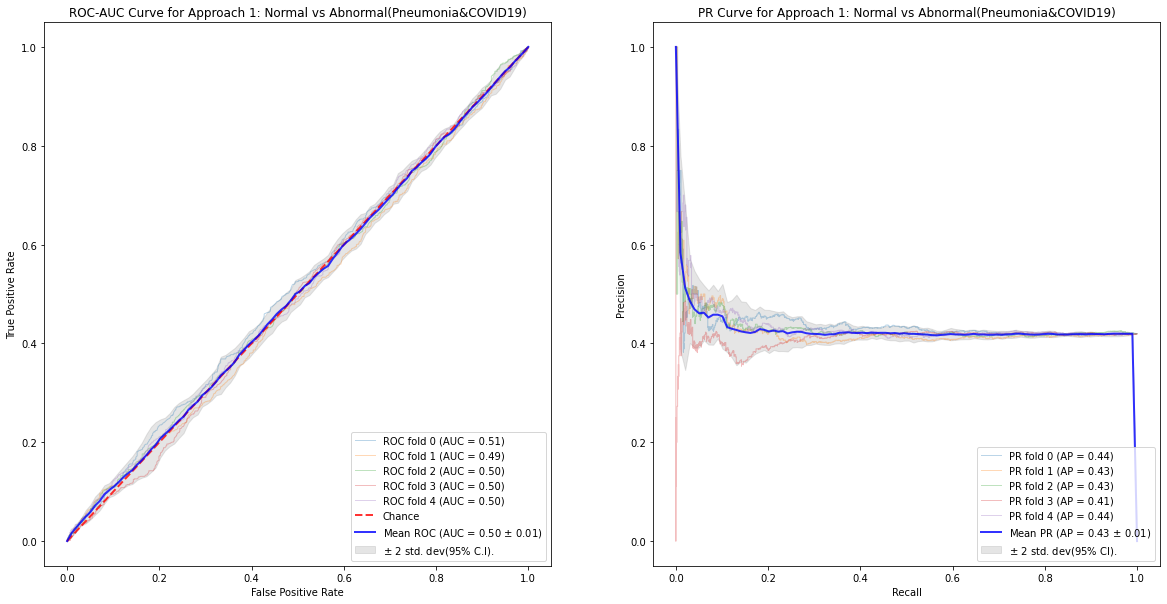

In [78]:
#sanity check should report class_count for train1 only have pneumonia + COVID
features = train_patch.columns[:-1]
weights = [] 

#want normal vs abnormal
normal, abnormal = hf.partition(train_patch.values,'normal')
covid, pneumonia = hf.partition(abnormal,'COVID-19')

#encode normal as 0
normal = hf.encode_Y(normal, 'random')

#encode Y such that COVID-19 is 1, and pnuemonia is 1
abnormal = hf.encode_Y(covid, 'COVID-19')
abnormal += (hf.encode_Y(pneumonia, 'pneumonia'))
train1 = normal + abnormal

#want normal vs abnormal
print("class counts: ", hf.class_counts(train1))

#this only works, if train is all numerical, because if not, np.array will
#convert all elements to same d_types 
train = np.array(train1)
X, y =  train[:,0:-1], train[:,-1]

tprs = []
aucs = []

precision = []
ap = []

mean_fpr = np.linspace(0, 1, 100)
mean_recall = np.linspace(0, 1, 100)

skf = StratifiedKFold(n_splits=5, random_state=None, shuffle=True)
feature_weights = []
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

for i , (train_index, test_index) in enumerate(skf.split(X, y)):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]
  
  regr = RandomForestClassifier(max_features = 10, n_estimators = 5000, class_weight = 'balanced',n_jobs = -1)
  regr.fit(X_train, y_train)
  y_predict = regr.predict_proba(X_test)
  COVID_predict = y_predict[:,-1]

  #record most important weights 
  if weights == []:
    weights = regr.feature_importances_
  else:
    weights = np.vstack((weights, regr.feature_importances_))
  
  #pr curve 
  viz_pr = plot_precision_recall_curve(regr, X_test,np.array(y_test), name = 'PR fold {}'.format(i),
                                      alpha = 0.3, lw = 1, ax=ax[1])
  interp_precision = np.interp(mean_recall, viz_pr.recall[::-1], viz_pr.precision[::-1])
  interp_precision[0]= 1
  precision.append(interp_precision)
  ap.append(viz_pr.average_precision)

  #X_test is a set of features, y_test is a 1d array 
  viz = plot_roc_curve(regr, X_test, np.array(y_test),
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax[0])
  interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
  interp_tpr[0] = 0.0
  tprs.append(interp_tpr)
  aucs.append(viz.roc_auc)

#==================Plot for PR curve ========================
mean_precision = np.mean(precision, axis = 0)
std_precision = np.std(precision, axis = 0)
mean_precision[-1] = 0
std_ap = np.std(ap,axis = 0)
mean_ap = auc(mean_recall, mean_precision)

ax[1].plot(mean_recall, mean_precision, color='b',
        label=r'Mean PR (AP = %0.2f $\pm$ %0.2f)' % (mean_ap, std_ap),
        lw=2, alpha=.8)

precision_upper = np.minimum(mean_precision + 2*std_precision, 1)
precision_lower = np.maximum(mean_precision - 2*std_precision, 0)
ax[1].fill_between(mean_recall,  precision_lower,precision_upper, color='gray', alpha=.2,
                label=r'$\pm$ 2 std. dev(95% CI).')
ax[1].set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="PR Curve for Approach 1: Normal vs Abnormal(Pneumonia&COVID19)")
ax[1].legend(loc="lower right")

#==================Plot for roc_auc curve ==================
ax[0].plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax[0].plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + 2*std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - 2*std_tpr, 0)
ax[0].fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 2 std. dev(95% C.I).')
ax[0].set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="ROC-AUC Curve for Approach 1: Normal vs Abnormal(Pneumonia&COVID19)")
ax[0].legend(loc="lower right")
plt.show()

#### Ranked Factors (Figure 1)


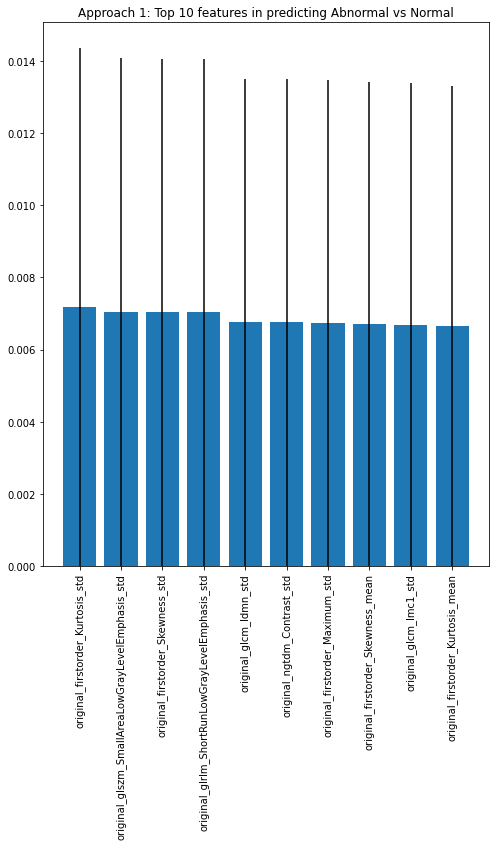

In [90]:
#================= ranked important factors ==================
importlib.reload(prediction_helpers)

title = "Approach 1: Top 10 features in predicting Abnormal vs Normal"
top_k_1= prediction_helpers.visualize_factors(features, weights,"approach1_predict1" ,title)

### ***Approach 1, Prediction 2***

class counts:  {0.0: 3925, 1.0: 46}


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


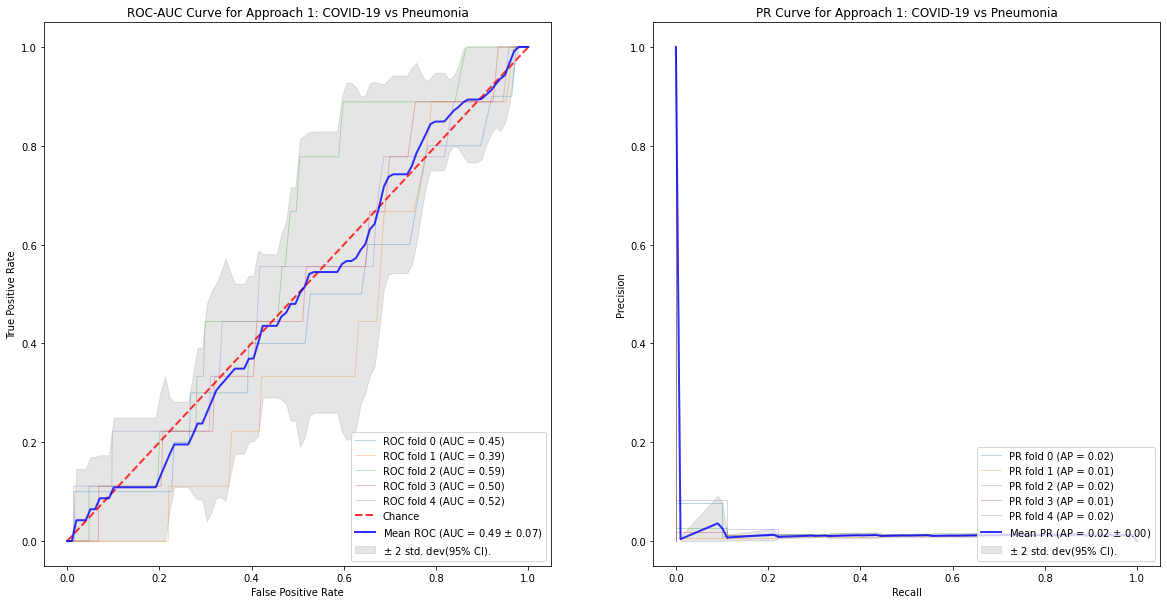

In [61]:
#want normal vs abnormal
normal, abnormal = hf.partition(train_patch.values,'normal')
#covid, pneumonia = hf.partition(abnormal,'COVID-19')

#encode COVID-19 as 1 and pneumonia as 0
train1 = hf.encode_Y(abnormal, 'COVID-19')
print("class counts: ", hf.class_counts(train1))

#sanity check should report class_count for train1 only have pneumonia + COVID
features = train_patch.columns
weights2 = [] 

#this only works, if train is all numerical, because if not, np.array will
#convert all elements to same d_types 
train = np.array(train1)
X, y =  train[:,0:-1], train[:,-1]

tprs = []
aucs = []

precision = []
ap = []

mean_fpr = np.linspace(0, 1, 100)
mean_recall = np.linspace(0, 1, 100)

skf = StratifiedKFold(n_splits=5, random_state=5, shuffle=True)
feature_weights = []
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

for i , (train_index, test_index) in enumerate(skf.split(X, y)):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]
  
  regr = RandomForestClassifier(max_features = 10, n_estimators = 5000, class_weight = 'balanced',n_jobs = -1)
  regr.fit(X_train, y_train)
  y_predict = regr.predict_proba(X_test)
  COVID_predict = y_predict[:,-1]

  #record most important weights 
  if weights2 == []:
    weights2 = regr.feature_importances_
  else:
    weights2 = np.vstack((weights2, regr.feature_importances_))
  
  #pr curve 
  viz_pr = plot_precision_recall_curve(regr, X_test,np.array(y_test), name = 'PR fold {}'.format(i),
                                      alpha = 0.3, lw = 1, ax=ax[1])
  interp_precision = np.interp(mean_recall, viz_pr.recall[::-1], viz_pr.precision[::-1])
  interp_precision[0]= 1
  precision.append(interp_precision)
  ap.append(viz_pr.average_precision)

  #X_test is a set of features, y_test is a 1d array 
  viz = plot_roc_curve(regr, X_test, np.array(y_test),
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax[0])
  interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
  interp_tpr[0] = 0.0
  tprs.append(interp_tpr)
  aucs.append(viz.roc_auc)
#==================Plot for PR curve ========================
mean_precision = np.mean(precision, axis = 0)
std_precision = np.std(precision, axis = 0)
mean_precision[-1] = 0
std_ap = np.std(ap,axis = 0)
mean_ap = auc(mean_recall, mean_precision)

ax[1].plot(mean_recall, mean_precision, color='b',
        label=r'Mean PR (AP = %0.2f $\pm$ %0.2f)' % (mean_ap, std_ap),
        lw=2, alpha=.8)

precision_upper = np.minimum(mean_precision + 2*std_precision, 1)
precision_lower = np.maximum(mean_precision - 2*std_precision, 0)
ax[1].fill_between(mean_recall,  precision_lower,precision_upper, color='gray', alpha=.2,
                label=r'$\pm$ 2 std. dev(95% CI).')
ax[1].set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="PR Curve for Approach 1: COVID-19 vs Pneumonia")
ax[1].legend(loc="lower right")


#==================Plot for roc_auc curve ==================
ax[0].plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax[0].plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + 2*std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - 2*std_tpr, 0)
ax[0].fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 2 std. dev(95% CI).')
ax[0].set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="ROC-AUC Curve for Approach 1: COVID-19 vs Pneumonia")
ax[0].legend(loc="lower right")
plt.show()

####Ranked Factors (Figure 2)

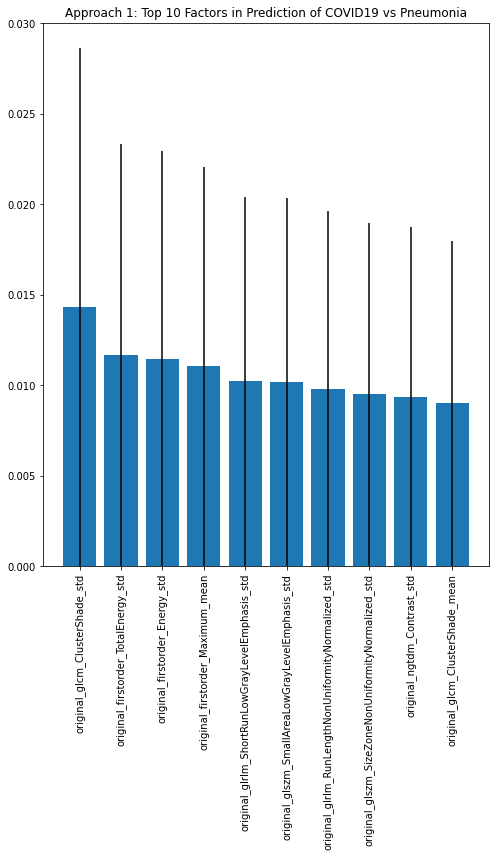

In [91]:
#================= ranked important factors ==================
import prediction_helpers 
#sum_weights2= weights2.sum(axis = 0)
title = "Approach 1: Top 10 Factors in Prediction of COVID19 vs Pneumonia"
ranked_wts2 =  prediction_helpers.visualize_factors(features[:-1], weights2,"approach1_predict2", title)

### Approach 1, Prediction 2 (Downsample)





class counts:  {0.0: 46, 1.0: 46}


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43:

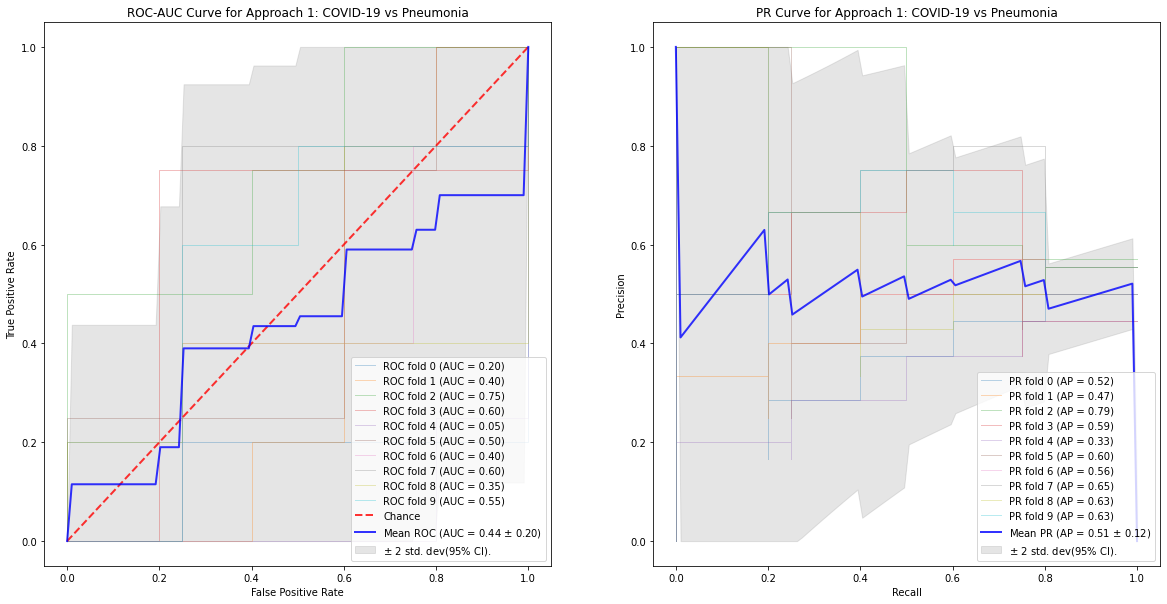

OSError: ignored

In [119]:
#want normal vs abnormal
normal, abnormal = hf.partition(train_patch.values,'normal')

covid, pneumonia= hf.partition(abnormal, 'COVID-19')
pneumonia = random.sample(population = pneumonia, k=len(covid))
abnormal = pneumonia + covid


#encode COVID-19 as 1 and pneumonia as 0
train1 = hf.encode_Y(abnormal, 'COVID-19')
print("class counts: ", hf.class_counts(train1))

#sanity check should report class_count for train1 only have pneumonia + COVID
features = train_patch.columns
weights2_2 = [] 

#this only works, if train is all numerical, because if not, np.array will
#convert all elements to same d_types 
train = np.array(train1)
X, y =  train[:,0:-1], train[:,-1]

tprs = []
aucs = []

precision = []
ap = []

mean_fpr = np.linspace(0, 1, 100)
mean_recall = np.linspace(0, 1, 100)

skf = StratifiedKFold(n_splits=10, random_state=5, shuffle=True)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

for i , (train_index, test_index) in enumerate(skf.split(X, y)):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]
  
  regr = RandomForestClassifier(max_features = 10, n_estimators = 10000, class_weight = 'balanced',n_jobs = -1)
  regr.fit(X_train, y_train)
  y_predict = regr.predict_proba(X_test)
  COVID_predict = y_predict[:,-1]

  #record most important weights 
  if weights2_2 == []:
    weights2_2 = regr.feature_importances_
  else:
    weights2_2 = np.vstack((weights2, regr.feature_importances_))
  
  #pr curve 
  viz_pr = plot_precision_recall_curve(regr, X_test,np.array(y_test), name = 'PR fold {}'.format(i),
                                      alpha = 0.3, lw = 1, ax=ax[1])
  interp_precision = np.interp(mean_recall, viz_pr.recall[::-1], viz_pr.precision[::-1])
  interp_precision[0]= 1
  precision.append(interp_precision)
  ap.append(viz_pr.average_precision)

  #X_test is a set of features, y_test is a 1d array 
  viz = plot_roc_curve(regr, X_test, np.array(y_test),
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax[0])
  interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
  interp_tpr[0] = 0.0
  tprs.append(interp_tpr)
  aucs.append(viz.roc_auc)
#==================Plot for PR curve ========================
mean_precision = np.mean(precision, axis = 0)
std_precision = np.std(precision, axis = 0)
mean_precision[-1] = 0
std_ap = np.std(ap,axis = 0)
mean_ap = auc(mean_recall, mean_precision)

ax[1].plot(mean_recall, mean_precision, color='b',
        label=r'Mean PR (AP = %0.2f $\pm$ %0.2f)' % (mean_ap, std_ap),
        lw=2, alpha=.8)

precision_upper = np.minimum(mean_precision + 2*std_precision, 1)
precision_lower = np.maximum(mean_precision - 2*std_precision, 0)
ax[1].fill_between(mean_recall,  precision_lower,precision_upper, color='gray', alpha=.2,
                label=r'$\pm$ 2 std. dev(95% CI).')
ax[1].set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="PR Curve for Approach 1: COVID-19 vs Pneumonia")
ax[1].legend(loc="lower right")

#==================Plot for roc_auc curve ==================
ax[0].plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax[0].plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + 2*std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - 2*std_tpr, 0)
ax[0].fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 2 std. dev(95% CI).')
ax[0].set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="ROC-AUC Curve for Approach 1: COVID-19 vs Pneumonia")
ax[0].legend(loc="lower right")
plt.show()

#================= ranked important factors ==================
import prediction_helpers 
#sum_weights2= weights2.sum(axis = 0)
title = "Approach 1(downsample): Top 10 Factors in Prediction of COVID19 vs Pneumonia"
ranked_wts2 =  prediction_helpers.visualize_factors(features[:-1], weights2_2,"approach1_predict2", title)

In [0]:
#================= ranked important factors ==================
import prediction_helpers 
#sum_weights2= weights2.sum(axis = 0)
title = "Approach 1(downsample): Top 10 Factors in Prediction of COVID19 vs Pneumonia"
ranked_wts2 =  prediction_helpers.visualize_factors(features[:-1], weights2_2,"approach1_predict2", title)


## **Approach 2:**

In [0]:
import helper_functions as hf
train_mask = pd.read_csv("mask_aggregator.csv", index_col = None)

### ***Approach 2: Prediction 1***




class counts:  {0.0: 5496, 1.0: 3961}


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


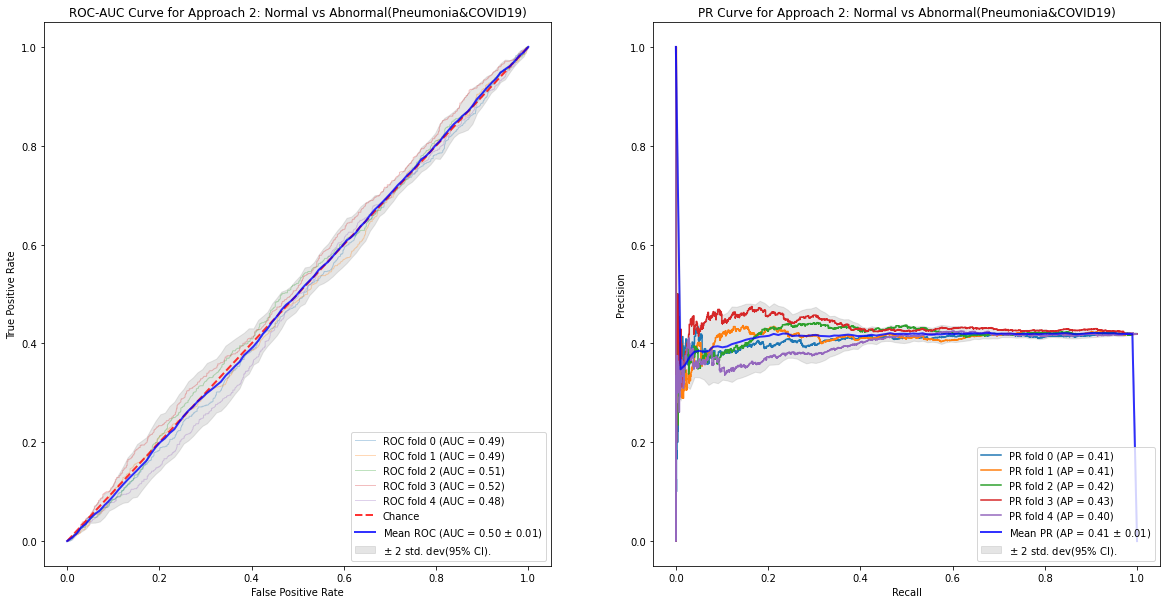

In [58]:
#sanity check should report class_count for train1 only have pneumonia + COVID
unwanted, train1 = hf.partition(train_mask,'abnormal')

#sanity check should report class_count for train1 only have pneumonia + COVID
features = train_mask.columns[:-1]
weights3 = [] 

#want normal vs abnormal
normal, abnormal = hf.partition(train_mask.values,'normal')
covid, pneumonia = hf.partition(abnormal,'COVID-19')

#encode normal as 0
normal = hf.encode_Y(normal, 'random')

#encode Y such that COVID-19 is 1, and pnuemonia is 1
abnormal = hf.encode_Y(covid, 'COVID-19')
abnormal += (hf.encode_Y(pneumonia, 'pneumonia'))
train1 = normal + abnormal

#want normal vs abnormal
print("class counts: ", hf.class_counts(train1))

#this only works, if train is all numerical, because if not, np.array will
#convert all elements to same d_types 
train = np.array(train1)
X, y =  train[:,0:-1], train[:,-1]

tprs = []
aucs = []
precision = []
ap = []

mean_fpr = np.linspace(0, 1, 100)
mean_recall = np.linspace(0, 1, 100)
weights3 = [] 

skf = StratifiedKFold(n_splits=5, random_state=None, shuffle=True)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

for i , (train_index, test_index) in enumerate(skf.split(X, y)):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]
  
  regr = RandomForestClassifier(max_features = 10, n_estimators = 5000, class_weight = 'balanced',n_jobs = -1)
  regr.fit(X_train, y_train)
  y_predict = regr.predict_proba(X_test)
  COVID_predict = y_predict[:,-1]

  #record most important weights 
  if weights3 == []:
    weights3 = regr.feature_importances_
  else:
    weights3 = np.vstack((weights3, regr.feature_importances_))
  
  #pr curve 
  viz_pr = plot_precision_recall_curve(regr, X_test,np.array(y_test),
                                       name = 'PR fold {}'.format(i),
                                       ax=ax[1])
  
  interp_precision = np.interp(mean_recall, viz_pr.recall[::-1], viz_pr.precision[::-1])
  interp_precision[0]= 1.0
  precision.append(interp_precision)
  ap.append(viz_pr.average_precision)

  #X_test is a set of features, y_test is a 1d array 
  viz = plot_roc_curve(regr, X_test, np.array(y_test),
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax[0])
  interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
  interp_tpr[0] = 0.0
  tprs.append(interp_tpr)
  aucs.append(viz.roc_auc)

#==================Plot for PR curve ========================
mean_precision = np.mean(precision, axis = 0)
std_precision = np.std(precision, axis = 0)
mean_precision[-1] = 0
std_ap = np.std(ap,axis = 0)
mean_ap = auc(mean_recall, mean_precision)

ax[1].plot(mean_recall, mean_precision, color='b',
        label=r'Mean PR (AP = %0.2f $\pm$ %0.2f)' % (mean_ap, std_ap),
        lw=2, alpha=.8)

precision_upper = np.minimum(mean_precision + 2*std_precision, 1)
precision_lower = np.maximum(mean_precision - 2*std_precision, 0)
ax[1].fill_between(mean_recall,  precision_lower,precision_upper, color='gray', alpha=.2,
                label=r'$\pm$ 2 std. dev(95% CI).')
ax[1].set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="PR Curve for Approach 2: Normal vs Abnormal(Pneumonia&COVID19)")
ax[1].legend(loc="lower right")
#==================Plot for roc_auc curve ==================
ax[0].plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax[0].plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + 2*std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - 2*std_tpr, 0)
ax[0].fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 2 std. dev(95% CI).')
ax[0].set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="ROC-AUC Curve for Approach 2: Normal vs Abnormal(Pneumonia&COVID19)")
ax[0].legend(loc="lower right")
pickle.dump(ax, open('approach2_prediction1.pickle', 'wb'))
plt.show()

####Ranked Factors (Figure 3)

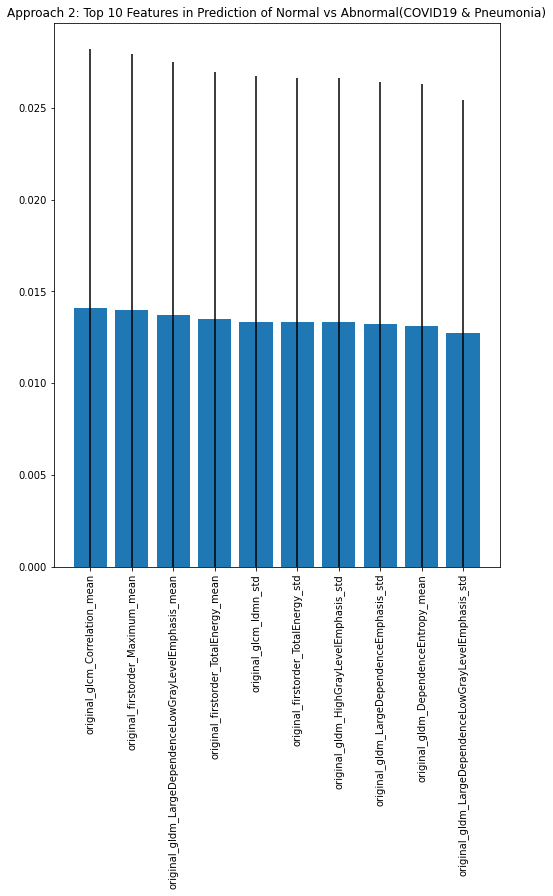

In [92]:
#import prediction_helpers 
import importlib
import prediction_helpers
importlib.reload(prediction_helpers)
title = "Approach 2: Top 10 Features in Prediction of Normal vs Abnormal(COVID19 & Pneumonia)"
ranked_wts3 =  prediction_helpers.visualize_factors(features[:-1], weights3,"approach2_predict1", title)

### ***Approach 2: Prediction 2***

class counts:  {0.0: 3916, 1.0: 45}


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


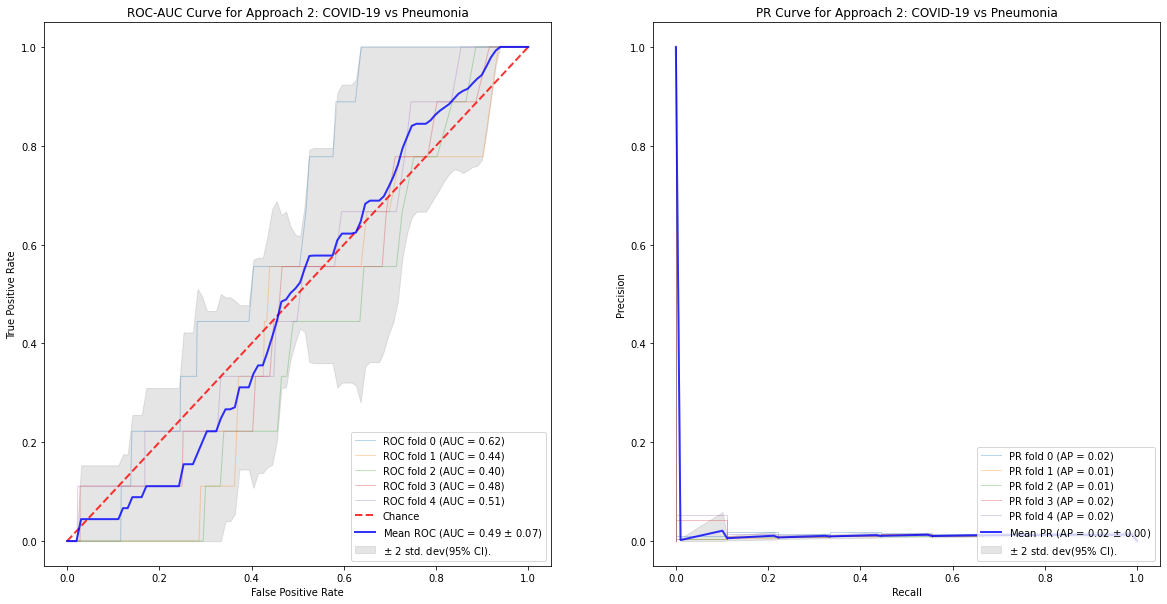

In [43]:
import random
#want normal vs abnormal
normal, abnormal = hf.partition(train_mask.values,'normal')

#encode COVID-19 as 1 and pneumonia as 0
train1 = hf.encode_Y(abnormal, 'COVID-19')
print("class counts: ", hf.class_counts(train1))

#sanity check should report class_count for train1 only have pneumonia + COVID
features = train_mask.columns[:-1]
weights4 = [] 

#this only works, if train is all numerical, because if not, np.array will
#convert all elements to same d_types 
train = np.array(train1)
X, y =  train[:,0:-1], train[:,-1]

tprs = []
aucs = []

precision = []
ap = []

mean_fpr = np.linspace(0, 1, 100)
mean_recall = np.linspace(0, 1, 100)

skf = StratifiedKFold(n_splits=5, random_state=5, shuffle=True)
feature_weights = []
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

for i , (train_index, test_index) in enumerate(skf.split(X, y)):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]
  
  regr = RandomForestClassifier(max_features = 10, n_estimators = 000, class_weight = 'balanced',n_jobs = -1)
  regr.fit(X_train, y_train)
  y_predict = regr.predict_proba(X_test)
  COVID_predict = y_predict[:,-1]

  #record most important weights 
  if weights4 == []:
    weights4 = regr.feature_importances_
  else:
    weights4 = np.vstack((weights4, regr.feature_importances_))
  
  #pr curve 
  viz_pr = plot_precision_recall_curve(regr, X_test,np.array(y_test), name = 'PR fold {}'.format(i),
                                      alpha = 0.3, lw = 1, ax=ax[1])
  
  interp_precision = np.interp(mean_recall, viz_pr.recall[::-1], viz_pr.precision[::-1])
  interp_precision[0]= 1
  precision.append(interp_precision)
  ap.append(viz_pr.average_precision)

  
  #X_test is a set of features, y_test is a 1d array 
  viz = plot_roc_curve(regr, X_test, np.array(y_test),
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax[0])
  interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
  interp_tpr[0] = 0.0
  tprs.append(interp_tpr)
  aucs.append(viz.roc_auc)
  
#==================Plot for PR curve ========================
mean_precision = np.mean(precision, axis = 0)
std_precision = np.std(precision, axis = 0)
mean_precision[-1] = 0
std_ap = np.std(ap,axis = 0)
mean_ap = auc(mean_recall, mean_precision)

ax[1].plot(mean_recall, mean_precision, color='b',
        label=r'Mean PR (AP = %0.2f $\pm$ %0.2f)' % (mean_ap, std_ap),
        lw=2, alpha=.8)

precision_upper = np.minimum(mean_precision + 2*std_precision, 1)
precision_lower = np.maximum(mean_precision - 2*std_precision, 0)
ax[1].fill_between(mean_recall,  precision_lower,precision_upper, color='gray', alpha=.2,
                label=r'$\pm$ 2 std. dev(95% CI).')
ax[1].set(xlim=[-.05, 1.05], ylim=[-0.05, 1.05],
       title="PR Curve for Approach 2: COVID-19 vs Pneumonia")
ax[1].legend(loc="lower right")

#==================Plot for roc_auc curve ==================
ax[0].plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax[0].plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)
std_tpr = np.std(tprs, axis=0)

# to get 95% confidence interval, use 2 standard deviation from mean 
tprs_upper = np.minimum(mean_tpr + 2*std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - 2*std_tpr, 0)

ax[0].fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 2 std. dev(95% CI).')
ax[0].set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="ROC-AUC Curve for Approach 2: COVID-19 vs Pneumonia")
ax[0].legend(loc="lower right")
plt.show()

#### Ranked Factors (Figure 4)

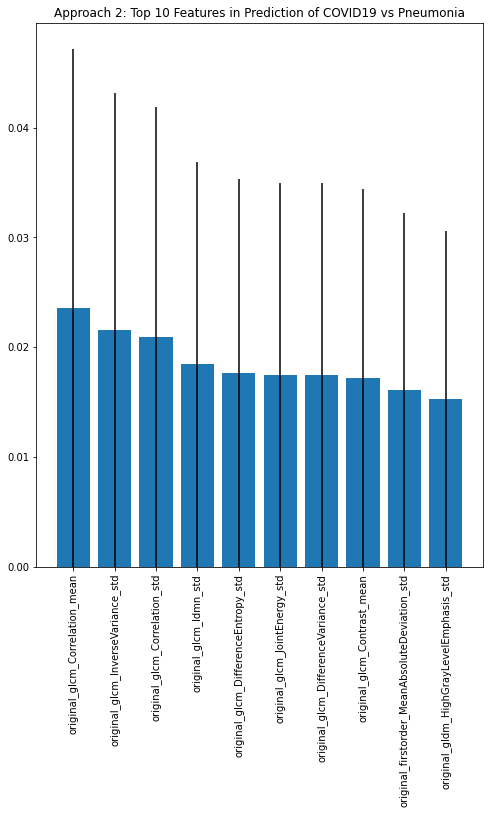

In [93]:
import prediction_helpers 
title = "Approach 2: Top 10 Features in Prediction of COVID19 vs Pneumonia"
ranked_wts4 =  prediction_helpers.visualize_factors(features, weights4,"approach2_predict2.npy", title)

### Approach 2: Prediction 2 (Downsample)

class counts:  {0.0: 45, 1.0: 45}


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


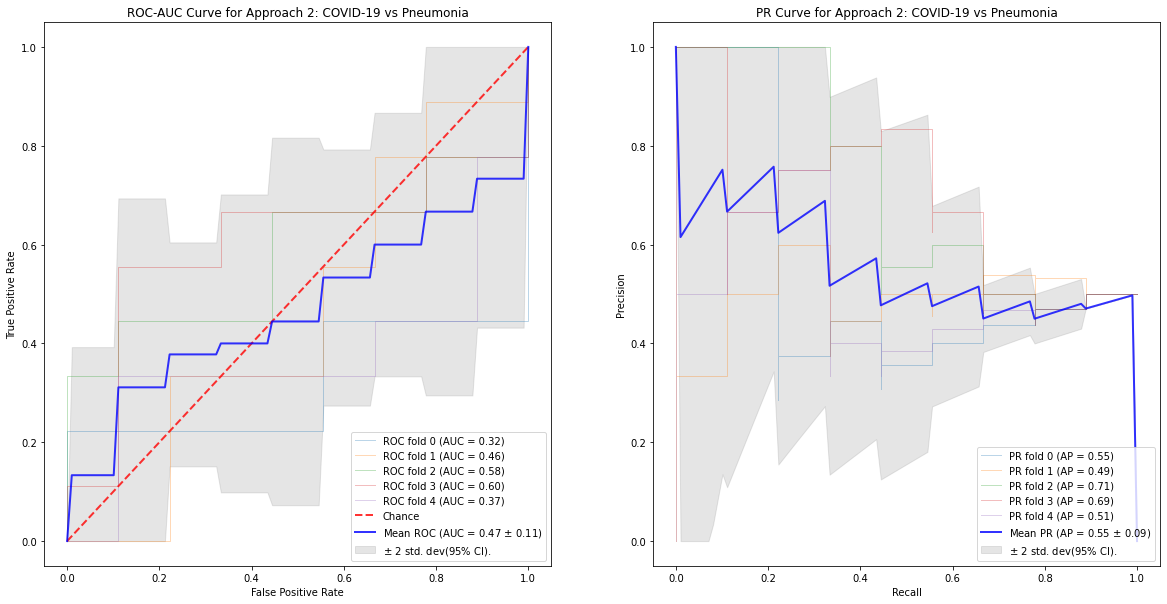

In [118]:
#want normal vs abnormal
normal, abnormal = hf.partition(train_mask.values,'normal')
covid, pneumonia = hf.partition(abnormal,'COVID-19')

pneumonia = random.sample(population=pneumonia, k=len(covid))
abnormal = pneumonia + covid 
#encode COVID-19 as 1 and pneumonia as 0
train1 = hf.encode_Y(abnormal, 'COVID-19')
print("class counts: ", hf.class_counts(train1))

#sanity check should report class_count for train1 only have pneumonia + COVID
features = train_mask.columns[:-1]
weights5 = [] 

#this only works, if train is all numerical, because if not, np.array will
#convert all elements to same d_types 
train = np.array(train1)
X, y =  train[:,0:-1], train[:,-1]

tprs = []
aucs = []

precision = []
ap = []

mean_fpr = np.linspace(0, 1, 100)
mean_recall = np.linspace(0, 1, 100)

skf = StratifiedKFold(n_splits=10, random_state=5, shuffle=True)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

for i , (train_index, test_index) in enumerate(skf.split(X, y)):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]
  
  regr = RandomForestClassifier(max_features = 10, n_estimators = 10000, class_weight = 'balanced',n_jobs = -1)
  regr.fit(X_train, y_train)
  y_predict = regr.predict_proba(X_test)
  COVID_predict = y_predict[:,-1]

  #record most important weights 
  if weights5 == []:
    weights5 = regr.feature_importances_
  else:
    weights5 = np.vstack((weights4, regr.feature_importances_))
  
  #pr curve 
  viz_pr = plot_precision_recall_curve(regr, X_test,np.array(y_test), name = 'PR fold {}'.format(i),
                                      alpha = 0.3, lw = 1, ax=ax[1])
  
  interp_precision = np.interp(mean_recall, viz_pr.recall[::-1], viz_pr.precision[::-1])
  interp_precision[0]= 1
  precision.append(interp_precision)
  ap.append(viz_pr.average_precision)

  
  #X_test is a set of features, y_test is a 1d array 
  viz = plot_roc_curve(regr, X_test, np.array(y_test),
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax[0])
  interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
  interp_tpr[0] = 0.0
  tprs.append(interp_tpr)
  aucs.append(viz.roc_auc)
  
#==================Plot for PR curve ========================
mean_precision = np.mean(precision, axis = 0)
std_precision = np.std(precision, axis = 0)
mean_precision[-1] = 0
std_ap = np.std(ap,axis = 0)
mean_ap = auc(mean_recall, mean_precision)

ax[1].plot(mean_recall, mean_precision, color='b',
        label=r'Mean PR (AP = %0.2f $\pm$ %0.2f)' % (mean_ap, std_ap),
        lw=2, alpha=.8)

precision_upper = np.minimum(mean_precision + 2*std_precision, 1)
precision_lower = np.maximum(mean_precision - 2*std_precision, 0)
ax[1].fill_between(mean_recall,  precision_lower,precision_upper, color='gray', alpha=.2,
                label=r'$\pm$ 2 std. dev(95% CI).')
ax[1].set(xlim=[-.05, 1.05], ylim=[-0.05, 1.05],
       title="PR Curve for Approach 2: COVID-19 vs Pneumonia")
ax[1].legend(loc="lower right")

#==================Plot for roc_auc curve ==================
ax[0].plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax[0].plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)
std_tpr = np.std(tprs, axis=0)

# to get 95% confidence interval, use 2 standard deviation from mean 
tprs_upper = np.minimum(mean_tpr + 2*std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - 2*std_tpr, 0)

ax[0].fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 2 std. dev(95% CI).')
ax[0].set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="ROC-AUC Curve for Approach 2: COVID-19 vs Pneumonia")
ax[0].legend(loc="lower right")
plt.show()

# **Evaluation of the approaches**

1. Which approach achieved overall better performance and why?

> Overall, the predictions from both approaches have similar mean ROC-AUC(0.5) and AP(0.02), and they are similar to random guessing unfortunately. There are several reasons why these approaches did not achieved  higher performance than random guessing, thus texture analysis approach is not the best choice despite changes in patch selections.
1. For prediction 1 task, patients with normal labeling could have underlying respiratory diseases, ie. chronic obstructive diseases, and show findings related abnormal characteristics.
2. For prediction 2 task, mean AP for both approaches are ~0 which is extremely low. It suggests the algorithm is unable to distinguish differences between COVID19-pneumonia and other pneumonia. It's likely that these pneumonias have non-specific pathological effects on the lungs, so the generated texture features from masks can't distinguish differences between them. Another more probable explanation is imbalanced dataset. To address the class imbalance, the algorithm assigned higher class weights to minority class, causing heavy penalty for predicting negative on rare positive cases in training set; but this results in low precision in test set. However, this is not ideal 
3. When using UNet to generate the lung mask, we could potentially lose peripheral information on pleural edema, which is important characteristic to distinguish between normal and abnormal states. 

2. What are the top 10 radiomic features that are used by the Random Forest in performing its classification?

>In approach 1's first task to predict abnormal vs normal, the top 10 important features used in all 5 cross-validations are ranked from highest to lowest. Please refer to Figure 1,2,3,4. These figures have shown that the standard deviations are higher than the weights themselves, suggesting randomness a huge factor and feature importance for these factors differ in the cross-validation. 

3. How did you handle the class imbalance for predicting pneumonia versus COVID-19?

> The class imbalance is addressed by giving a higher weights to minority class, COVID-19. However, it is not advised because the unequal weights given to COVID-19 group is too high causing low precision and recall. In an attempt to evaluate the effect of class imbalanced, I've tried to downsample for tasks 2 for both approaches and it shows improvements on increasing average precision. 

4. What further improvements would you make on Approach 2?

> Instead of using PyRadiomics to extract radiomics features, I suggest using convolutional neural network to encode via features automatically rather than just using radiomics features.

> To upsample the minority class, I suggest 1) data augmentation via linear transformation (rotate + flipped), 2) use the generative adversarial network(GAN) approach to generate more artificial images near the decision boundary where the machine keeps on failing and retrain the classifier to increase the robustness of the classifier. 

> Simply randomly sampling to downsize the pneumonia class could result in losing a good representation of pneumonia class. We could cluster similar images in pnuemonia and use stratify sampling on images in each cluster to make sure down-sample data has a good representation of that pneumonia population.  